In [2]:
RANDOM_SEED = 42

In [3]:
import pickle
import pathlib

import numpy as np
import pandas as pd

In [4]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)

c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\MachineLearning\projeto1-ml-ames\data


In [5]:
clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'
clean_data_path

WindowsPath('c:/Users/rodri/Documents/Rodrigo/Insper/SextoSemestre/MachineLearning/projeto1-ml-ames/data/processed/ames_clean.pkl')

In [6]:
with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2877 entries, 0 to 2929
Data columns (total 70 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   MS.SubClass      2877 non-null   category
 1   MS.Zoning        2877 non-null   category
 2   Lot.Frontage     2877 non-null   float64 
 3   Lot.Area         2877 non-null   float64 
 4   Lot.Shape        2877 non-null   category
 5   Land.Contour     2877 non-null   category
 6   Lot.Config       2877 non-null   category
 7   Land.Slope       2877 non-null   category
 8   Neighborhood     2877 non-null   category
 9   Bldg.Type        2877 non-null   category
 10  House.Style      2877 non-null   category
 11  Overall.Qual     2877 non-null   category
 12  Overall.Cond     2877 non-null   category
 13  Roof.Style       2877 non-null   category
 14  Mas.Vnr.Type     2877 non-null   category
 15  Mas.Vnr.Area     2877 non-null   float64 
 16  Exter.Qual       2877 non-null   category


In [8]:
model_data = data.copy()
model_data.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Lot.Shape,Land.Contour,Lot.Config,Land.Slope,Neighborhood,Bldg.Type,...,Sale.Type,Sale.Condition,SalePrice,Condition,HasShed,HasAlley,Exterior,Garage.Age,Remod.Age,House.Age
0,20,RL,141.0,31770.0,IR1,Lvl,Corner,Gtl,NAmes,1Fam,...,GroupedWD,Normal,5.332438,Norm,False,False,BrkFace,50.0,50.0,50.0
1,20,RH,80.0,11622.0,Reg,Lvl,Inside,Gtl,NAmes,1Fam,...,GroupedWD,Normal,5.021189,Roads,False,False,VinylSd,49.0,49.0,49.0
2,20,RL,81.0,14267.0,IR1,Lvl,Corner,Gtl,NAmes,1Fam,...,GroupedWD,Normal,5.235528,Norm,False,False,Wd Sdng,52.0,52.0,52.0
3,20,RL,93.0,11160.0,Reg,Lvl,Corner,Gtl,NAmes,1Fam,...,GroupedWD,Normal,5.387390,Norm,False,False,BrkFace,42.0,42.0,42.0
4,60,RL,74.0,13830.0,IR1,Lvl,Inside,Gtl,Gilbert,1Fam,...,GroupedWD,Normal,5.278525,Norm,False,False,VinylSd,13.0,12.0,13.0


In [9]:
categorical_columns = []
ordinal_columns = []
for col in model_data.select_dtypes('category').columns:
    if model_data[col].cat.ordered:
        ordinal_columns.append(col)
    else:
        categorical_columns.append(col)

In [10]:
numerical_data = data.select_dtypes('number').drop(columns='SalePrice').copy()
target = data['SalePrice'].copy()
numerical_data.corrwith(target).sort_values()



ordinal_columns

['Lot.Shape',
 'Land.Slope',
 'Overall.Qual',
 'Overall.Cond',
 'Exter.Qual',
 'Exter.Cond',
 'Heating.QC',
 'Electrical',
 'Kitchen.Qual',
 'Functional',
 'Paved.Drive',
 'Fence']

In [11]:
categorical_columns


['MS.SubClass',
 'MS.Zoning',
 'Land.Contour',
 'Lot.Config',
 'Neighborhood',
 'Bldg.Type',
 'House.Style',
 'Roof.Style',
 'Mas.Vnr.Type',
 'Foundation',
 'Bsmt.Qual',
 'Bsmt.Cond',
 'Bsmt.Exposure',
 'BsmtFin.Type.1',
 'BsmtFin.Type.2',
 'Central.Air',
 'Garage.Type',
 'Garage.Finish',
 'Sale.Type',
 'Sale.Condition',
 'Condition',
 'Exterior']

In [12]:
for col in ordinal_columns:
    codes, _ = pd.factorize(data[col], sort=True)
    model_data[col] = codes

In [13]:
model_data[ordinal_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2877 entries, 0 to 2929
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Lot.Shape     2877 non-null   int64
 1   Land.Slope    2877 non-null   int64
 2   Overall.Qual  2877 non-null   int64
 3   Overall.Cond  2877 non-null   int64
 4   Exter.Qual    2877 non-null   int64
 5   Exter.Cond    2877 non-null   int64
 6   Heating.QC    2877 non-null   int64
 7   Electrical    2877 non-null   int64
 8   Kitchen.Qual  2877 non-null   int64
 9   Functional    2877 non-null   int64
 10  Paved.Drive   2877 non-null   int64
 11  Fence         2877 non-null   int64
dtypes: int64(12)
memory usage: 292.2 KB


In [14]:
data['Lot.Shape'].value_counts()

Reg    1825
IR1     960
IR2      76
IR3      16
Name: Lot.Shape, dtype: int64

In [15]:
model_data['Lot.Shape'].value_counts()

0    1825
1     960
2      76
3      16
Name: Lot.Shape, dtype: int64

In [16]:
model_data['Exterior'].value_counts()

VinylSd    1024
HdBoard     439
MetalSd     432
Wd Sdng     401
Plywood     218
CemntBd     126
BrkFace      86
WdShing      55
Stucco       42
AsbShng      41
Other        13
Name: Exterior, dtype: int64

In [17]:
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()

,0,1,2,3,4
AsbShng,0,0,0,0,0
BrkFace,1,0,0,1,0
CemntBd,0,0,0,0,0
HdBoard,0,0,0,0,0
MetalSd,0,0,0,0,0
Plywood,0,0,0,0,0
Stucco,0,0,0,0,0
VinylSd,0,1,0,0,1
Wd Sdng,0,0,1,0,0
WdShing,0,0,0,0,0


In [18]:
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data, drop_first=True)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()

,0,1,2,3,4
BrkFace,1,0,0,1,0
CemntBd,0,0,0,0,0
HdBoard,0,0,0,0,0
MetalSd,0,0,0,0,0
Plywood,0,0,0,0,0
Stucco,0,0,0,0,0
VinylSd,0,1,0,0,1
Wd Sdng,0,0,1,0,0
WdShing,0,0,0,0,0
Other,0,0,0,0,0


In [19]:
model_data = pd.get_dummies(model_data, drop_first=True)

In [20]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2877 entries, 0 to 2929
Columns: 165 entries, Lot.Frontage to Exterior_Other
dtypes: bool(2), float64(34), int64(12), uint8(117)
memory usage: 1.4 MB


In [21]:
for cat in categorical_columns:
    dummies = []
    for col in model_data.columns:
        if col.startswith(cat + "_"):
            dummies.append(f'"{col}"')
    dummies_str = ', '.join(dummies)
    print(f'From column "{cat}" we made {dummies_str}\n')

From column "MS.SubClass" we made "MS.SubClass_30", "MS.SubClass_50", "MS.SubClass_60", "MS.SubClass_70", "MS.SubClass_80", "MS.SubClass_85", "MS.SubClass_90", "MS.SubClass_120", "MS.SubClass_160", "MS.SubClass_190", "MS.SubClass_Other"

From column "MS.Zoning" we made "MS.Zoning_RH", "MS.Zoning_RL", "MS.Zoning_RM"

From column "Land.Contour" we made "Land.Contour_HLS", "Land.Contour_Low", "Land.Contour_Lvl"

From column "Lot.Config" we made "Lot.Config_CulDSac", "Lot.Config_FR2", "Lot.Config_FR3", "Lot.Config_Inside"

From column "Neighborhood" we made "Neighborhood_BrDale", "Neighborhood_BrkSide", "Neighborhood_ClearCr", "Neighborhood_CollgCr", "Neighborhood_Crawfor", "Neighborhood_Edwards", "Neighborhood_Gilbert", "Neighborhood_IDOTRR", "Neighborhood_MeadowV", "Neighborhood_Mitchel", "Neighborhood_NAmes", "Neighborhood_NPkVill", "Neighborhood_NWAmes", "Neighborhood_NoRidge", "Neighborhood_NridgHt", "Neighborhood_OldTown", "Neighborhood_SWISU", "Neighborhood_Sawyer", "Neighborhood_Sa

In [22]:
X = model_data.drop(columns=['SalePrice']).copy()
y = model_data['SalePrice'].copy()

In [23]:
X.values, y.values

(array([[141.0, 31770.0, 1, ..., 0, 0, 0],
        [80.0, 11622.0, 0, ..., 0, 0, 0],
        [81.0, 14267.0, 1, ..., 1, 0, 0],
        ...,
        [62.0, 10441.0, 0, ..., 0, 0, 0],
        [77.0, 10010.0, 0, ..., 0, 0, 0],
        [74.0, 9627.0, 0, ..., 0, 0, 0]], dtype=object),
 array([5.33243846, 5.0211893 , 5.23552845, ..., 5.12057393, 5.23044892,
        5.27415785]))

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_SEED,
)


In [26]:
X.shape, Xtrain.shape, Xtest.shape

((2877, 164), (2157, 164), (720, 164))

In [27]:
y.shape, ytrain.shape, ytest.shape

((2877,), (2157,), (720,))

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV



grid_search_forest = GridSearchCV(
    RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1),
    {'n_estimators': [300, 675, 900]},
    cv=4, 
    n_jobs=-1, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)

grid_search_tree = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_SEED),
    {'max_depth': [3, 5, 7]},
    cv=4,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    return_train_score=True
)


In [52]:
grid_search_forest.fit(Xtrain, ytrain)
forest_reg = grid_search_forest.best_estimator_
forest_reg_scores = cross_val_score(forest_reg, Xtrain, ytrain, 
                                    scoring="neg_mean_squared_error", cv=8, n_jobs=-1)
forest_reg_rmse_scores = np.sqrt(-forest_reg_scores)

In [58]:
forest_reg

RandomForestRegressor(n_estimators=3000, n_jobs=-1, random_state=42)

In [30]:
grid_search_tree.fit(Xtrain, ytrain)
tree_reg = grid_search_tree.best_estimator_
tree_reg_scores = cross_val_score(tree_reg, Xtrain, ytrain, 
                                  scoring="neg_mean_squared_error", cv=8, n_jobs=-1)
tree_reg_rmse_scores = np.sqrt(-tree_reg_scores)

In [53]:
print("Random Forest Regressor:")
print(forest_reg_rmse_scores)
print(forest_reg_rmse_scores.mean())
print("\nDecision Tree Regressor:")
print(tree_reg_rmse_scores)
print(tree_reg_rmse_scores.mean())

Random Forest Regressor:
[0.05427539 0.04854912 0.06535914 0.05867113 0.05025961 0.0525092
 0.05920533 0.06166042]
0.05631116746454058

Decision Tree Regressor:
[0.07466032 0.06974786 0.08141566 0.08158875 0.07892358 0.07938374
 0.07702557 0.08298304]
0.07821606340047571


In [32]:
# testando um teste parametrico
from scipy.stats import ttest_ind

def compara_scores(scores_1, scores_2):
    t_stat, p_value = ttest_ind(scores_1, scores_2, equal_var=False)
    print("Valor da estatística t: {:.2f}".format(t_stat))
    print("Valor-p: {}".format(p_value))

In [33]:
from scipy.stats import mannwhitneyu

U, p_value = mannwhitneyu(forest_reg_rmse_scores, tree_reg_rmse_scores)
print('U =', U)
print('p-value =', p_value)

U = 0.0
p-value = 0.0001554001554001554


In [34]:
compara_scores(forest_reg_rmse_scores, tree_reg_rmse_scores)

Valor da estatística t: -8.44
Valor-p: 1.3390880807951545e-06


In [35]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [36]:
def outro_experimento(msg, pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_pred, y_test))

    print(f'{msg}:')
    print(f'RMSE: {RMSE}')
    print()

In [37]:
poly_reg = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('std_scaler', StandardScaler()),
    ('reg', forest_reg)
])

In [38]:
# outro_experimento('Random Forest com PolynomialFeatures', poly_reg, Xtrain, ytrain, Xtest, ytest)

In [39]:
# stacking regressors -> Random Forest + Decision Tree + Lasso
from sklearn.ensemble import StackingRegressor
# import gradient boosting regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

# Grid search for Gradient Boosting Regressor
grid_search_gbr = GridSearchCV(
    GradientBoostingRegressor(random_state=RANDOM_SEED),
    {'n_estimators': [100, 600, 900], 'max_depth': [3, 5, 7]},
    cv=4,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

grid_search_gbr.fit(Xtrain, ytrain)
gbr_reg = grid_search_gbr.best_estimator_
print(gbr_reg)


GradientBoostingRegressor(n_estimators=900, random_state=42)


In [40]:
gbr_reg

GradientBoostingRegressor(n_estimators=900, random_state=42)

In [41]:
# Lasso GridSearch
grid_search_lasso = GridSearchCV(
    Lasso(random_state=RANDOM_SEED),
    {'alpha': [0.1, 0.5, 1.0]},
    cv=4,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

grid_search_lasso.fit(Xtrain, ytrain)
lasso_reg = grid_search_lasso.best_estimator_
print(lasso_reg)

Lasso(alpha=0.1, random_state=42)


In [54]:

estimators = [
    ('rf', forest_reg),
    ('ls', lasso_reg),
    ('gb', gbr_reg)
    
]

stack_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge()
)

outro_experimento('Stacking Regressor', stack_reg, Xtrain, ytrain, Xtest, ytest)


Stacking Regressor:
RMSE: 0.05404171438494029



In [55]:
# Cross Validation of Stacking Regressor
from sklearn.model_selection import cross_val_score

stack_reg_scores = cross_val_score(stack_reg, Xtrain, ytrain,
                                      scoring="neg_mean_squared_error", cv=8, n_jobs=-1)    
stack_reg_rmse_scores = np.sqrt(-stack_reg_scores)

print(stack_reg_rmse_scores)
print(stack_reg_rmse_scores.mean())


[0.05200052 0.04386565 0.05713254 0.05128648 0.04255732 0.04438624
 0.05000536 0.05588154]
0.049639456152154746


In [ ]:
mean_scores = stack_reg_rmse_scores.mean()
# uma vez que o target está em log, precisamos fazer a transformação inversa
mean_scores = (10**mean_scores - 1) * 100
print(mean_scores)

Text(0.5, 1.0, 'Feature Importance (MDI)')

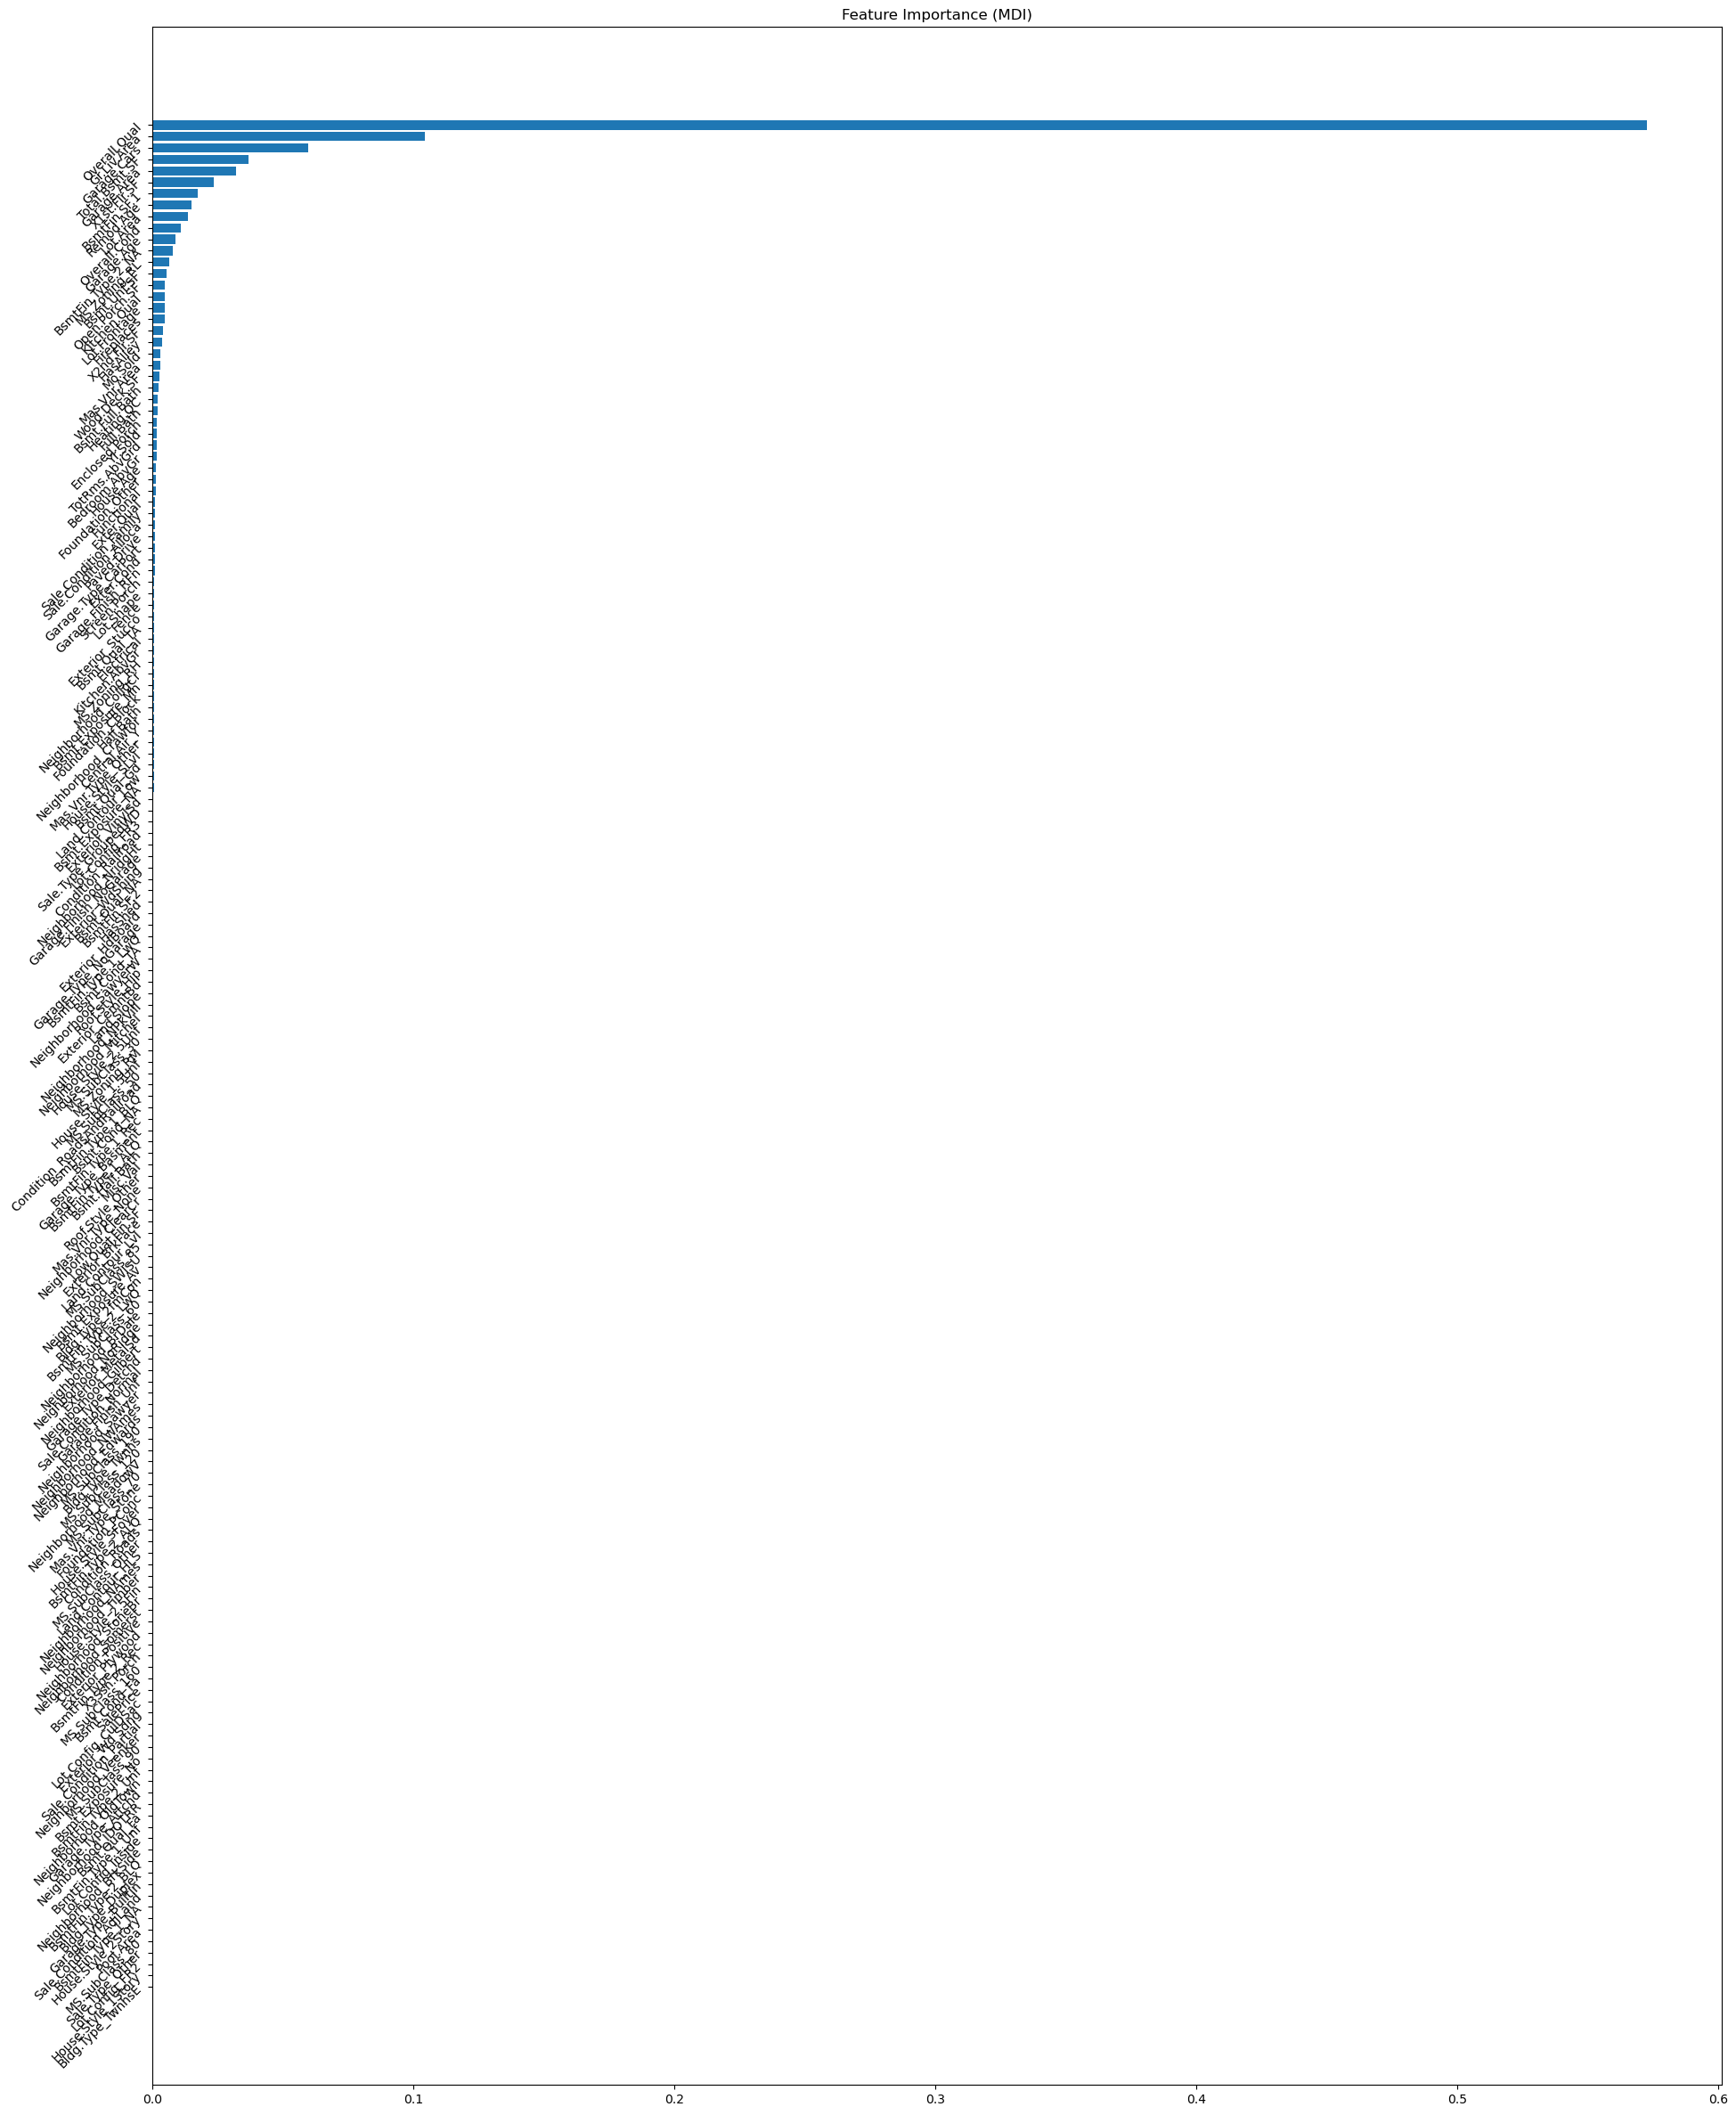

In [76]:
import matplotlib.pyplot as plt


feature_importance_forest = forest_reg.feature_importances_
sorted_idx = np.argsort(feature_importance_forest)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(50, 30))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_forest[sorted_idx], align="center")
plt.yticks(pos, np.array(model_data.columns)[sorted_idx], rotation=45, ha="right")
plt.title("Feature Importance (MDI)")

Text(0.5, 1.0, 'Feature Importance (MDI)')

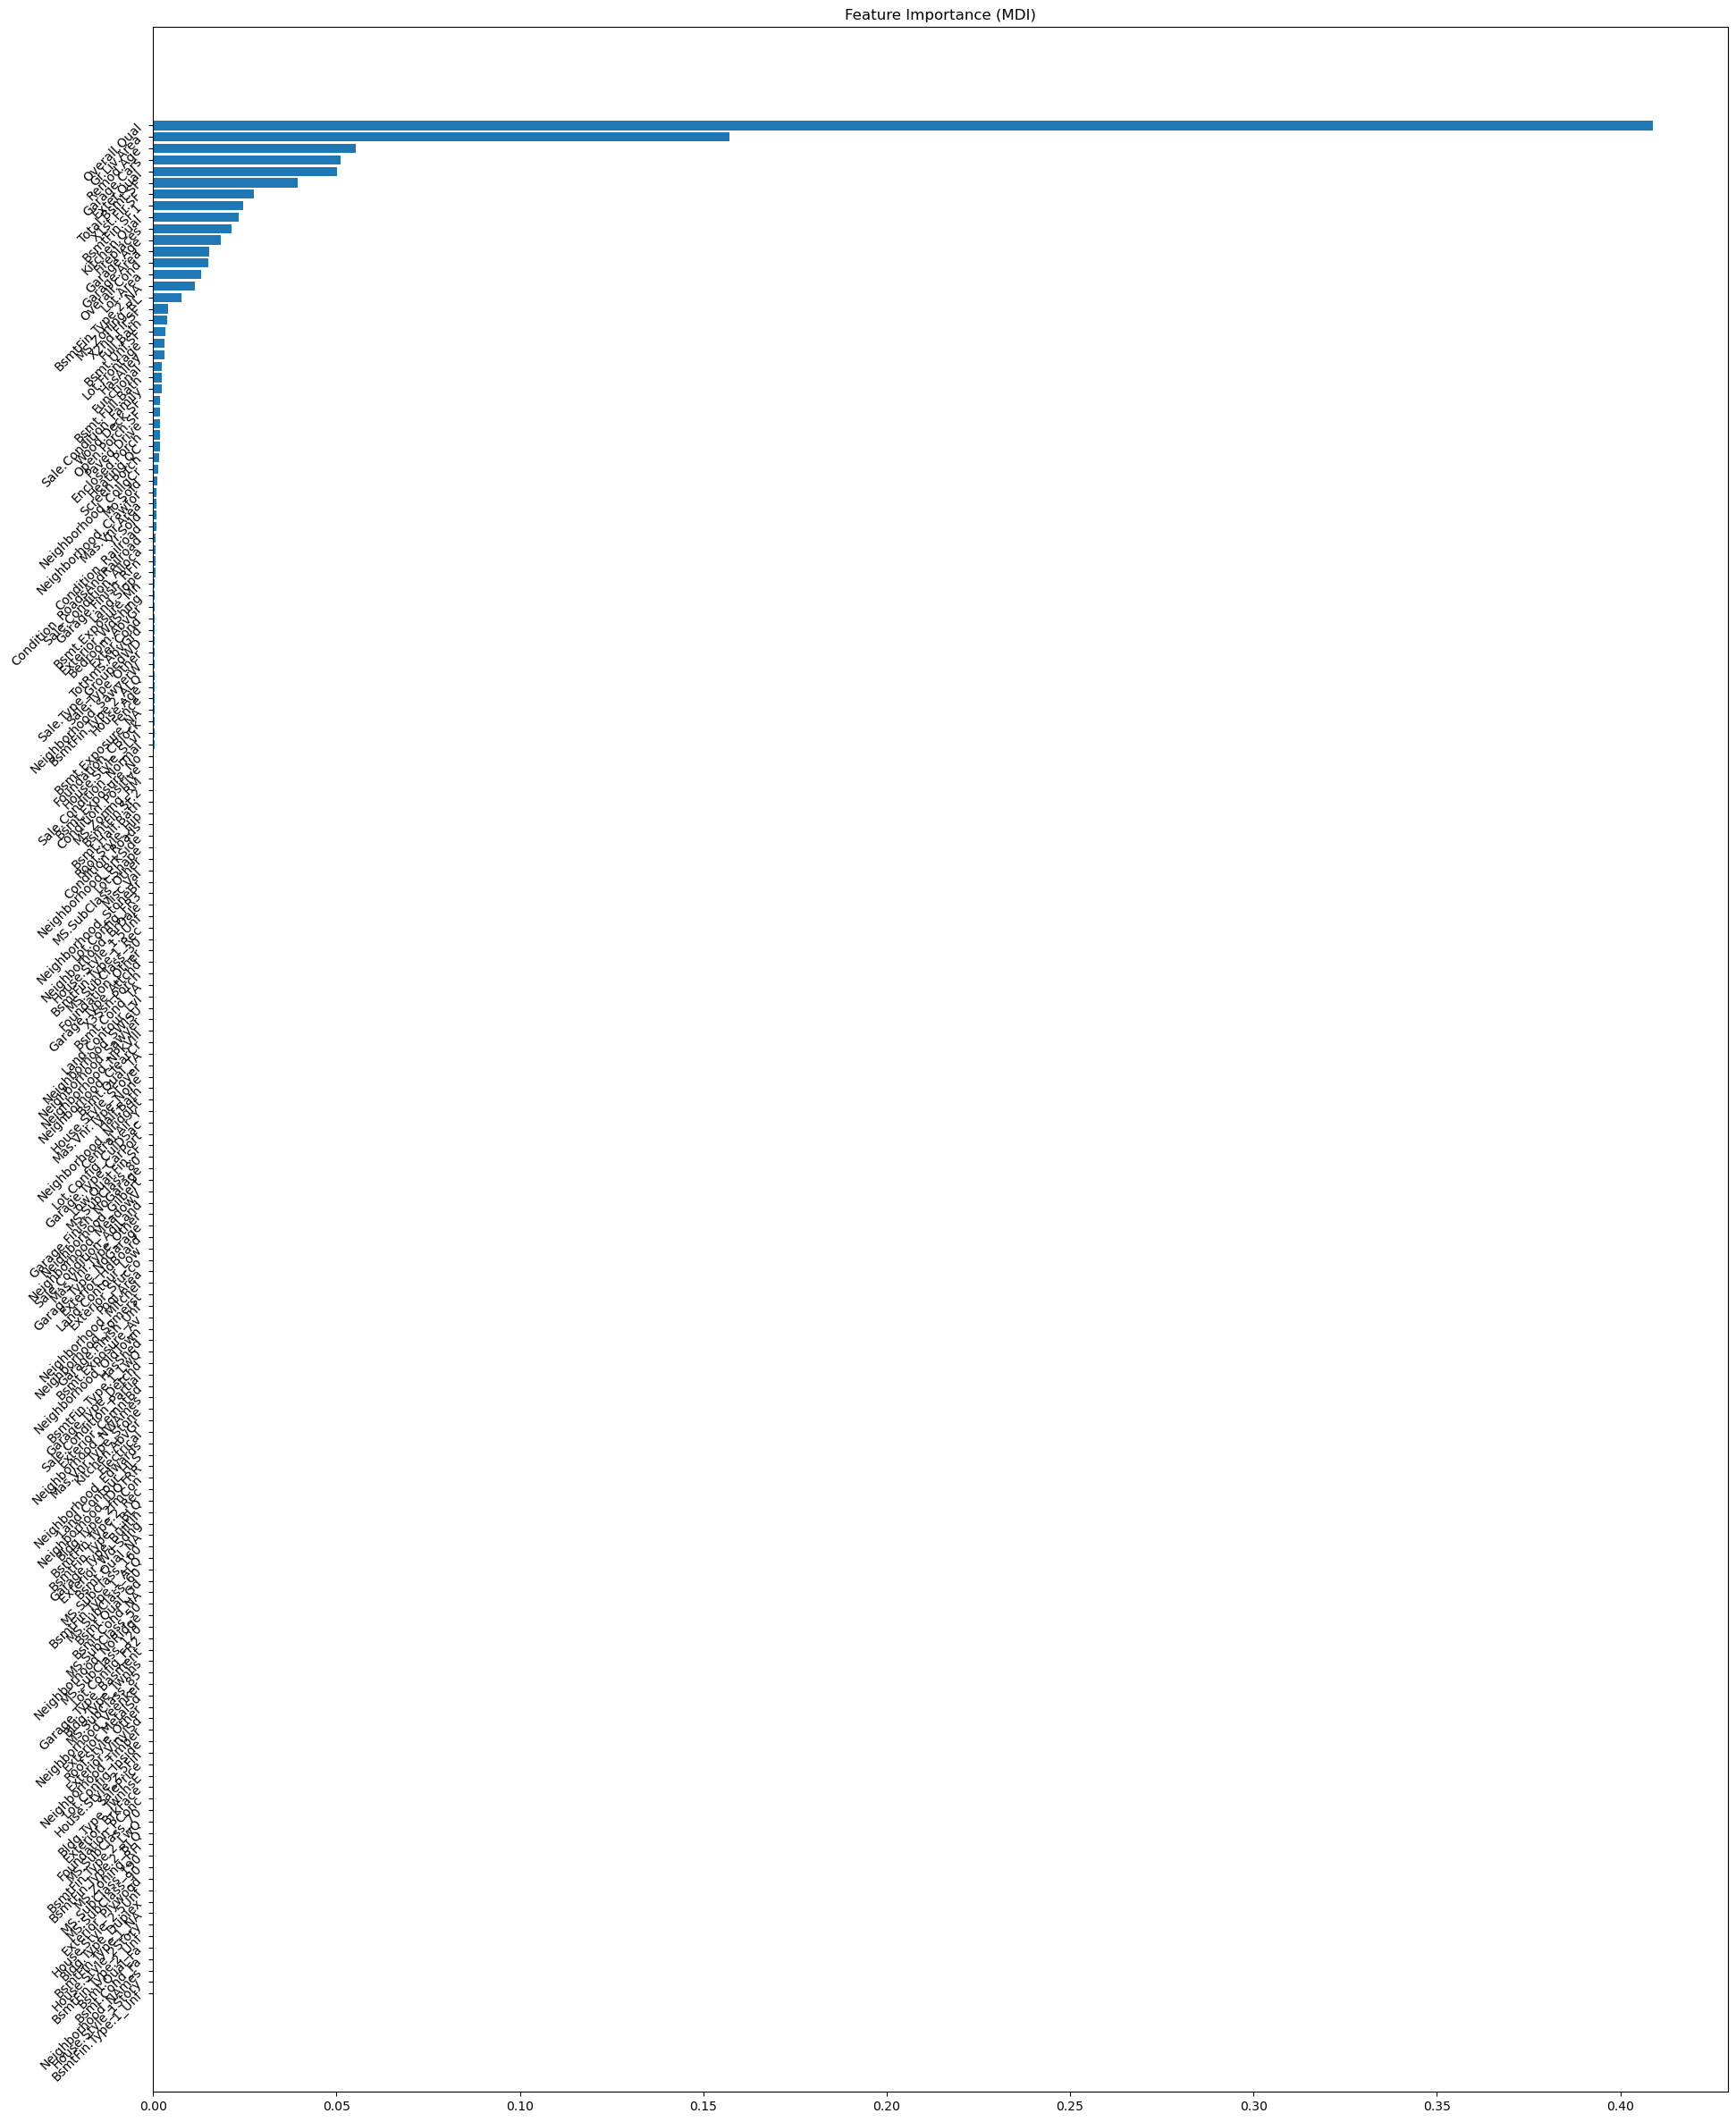

In [77]:
feature_importance_gbr = gbr_reg.feature_importances_
sorted_idx = np.argsort(feature_importance_gbr)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(50, 30))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_gbr[sorted_idx], align="center")
plt.yticks(pos, np.array(model_data.columns)[sorted_idx], rotation=45, ha="right")
plt.title("Feature Importance (MDI)")

Text(0.5, 1.0, 'Feature Importance (MDI)')

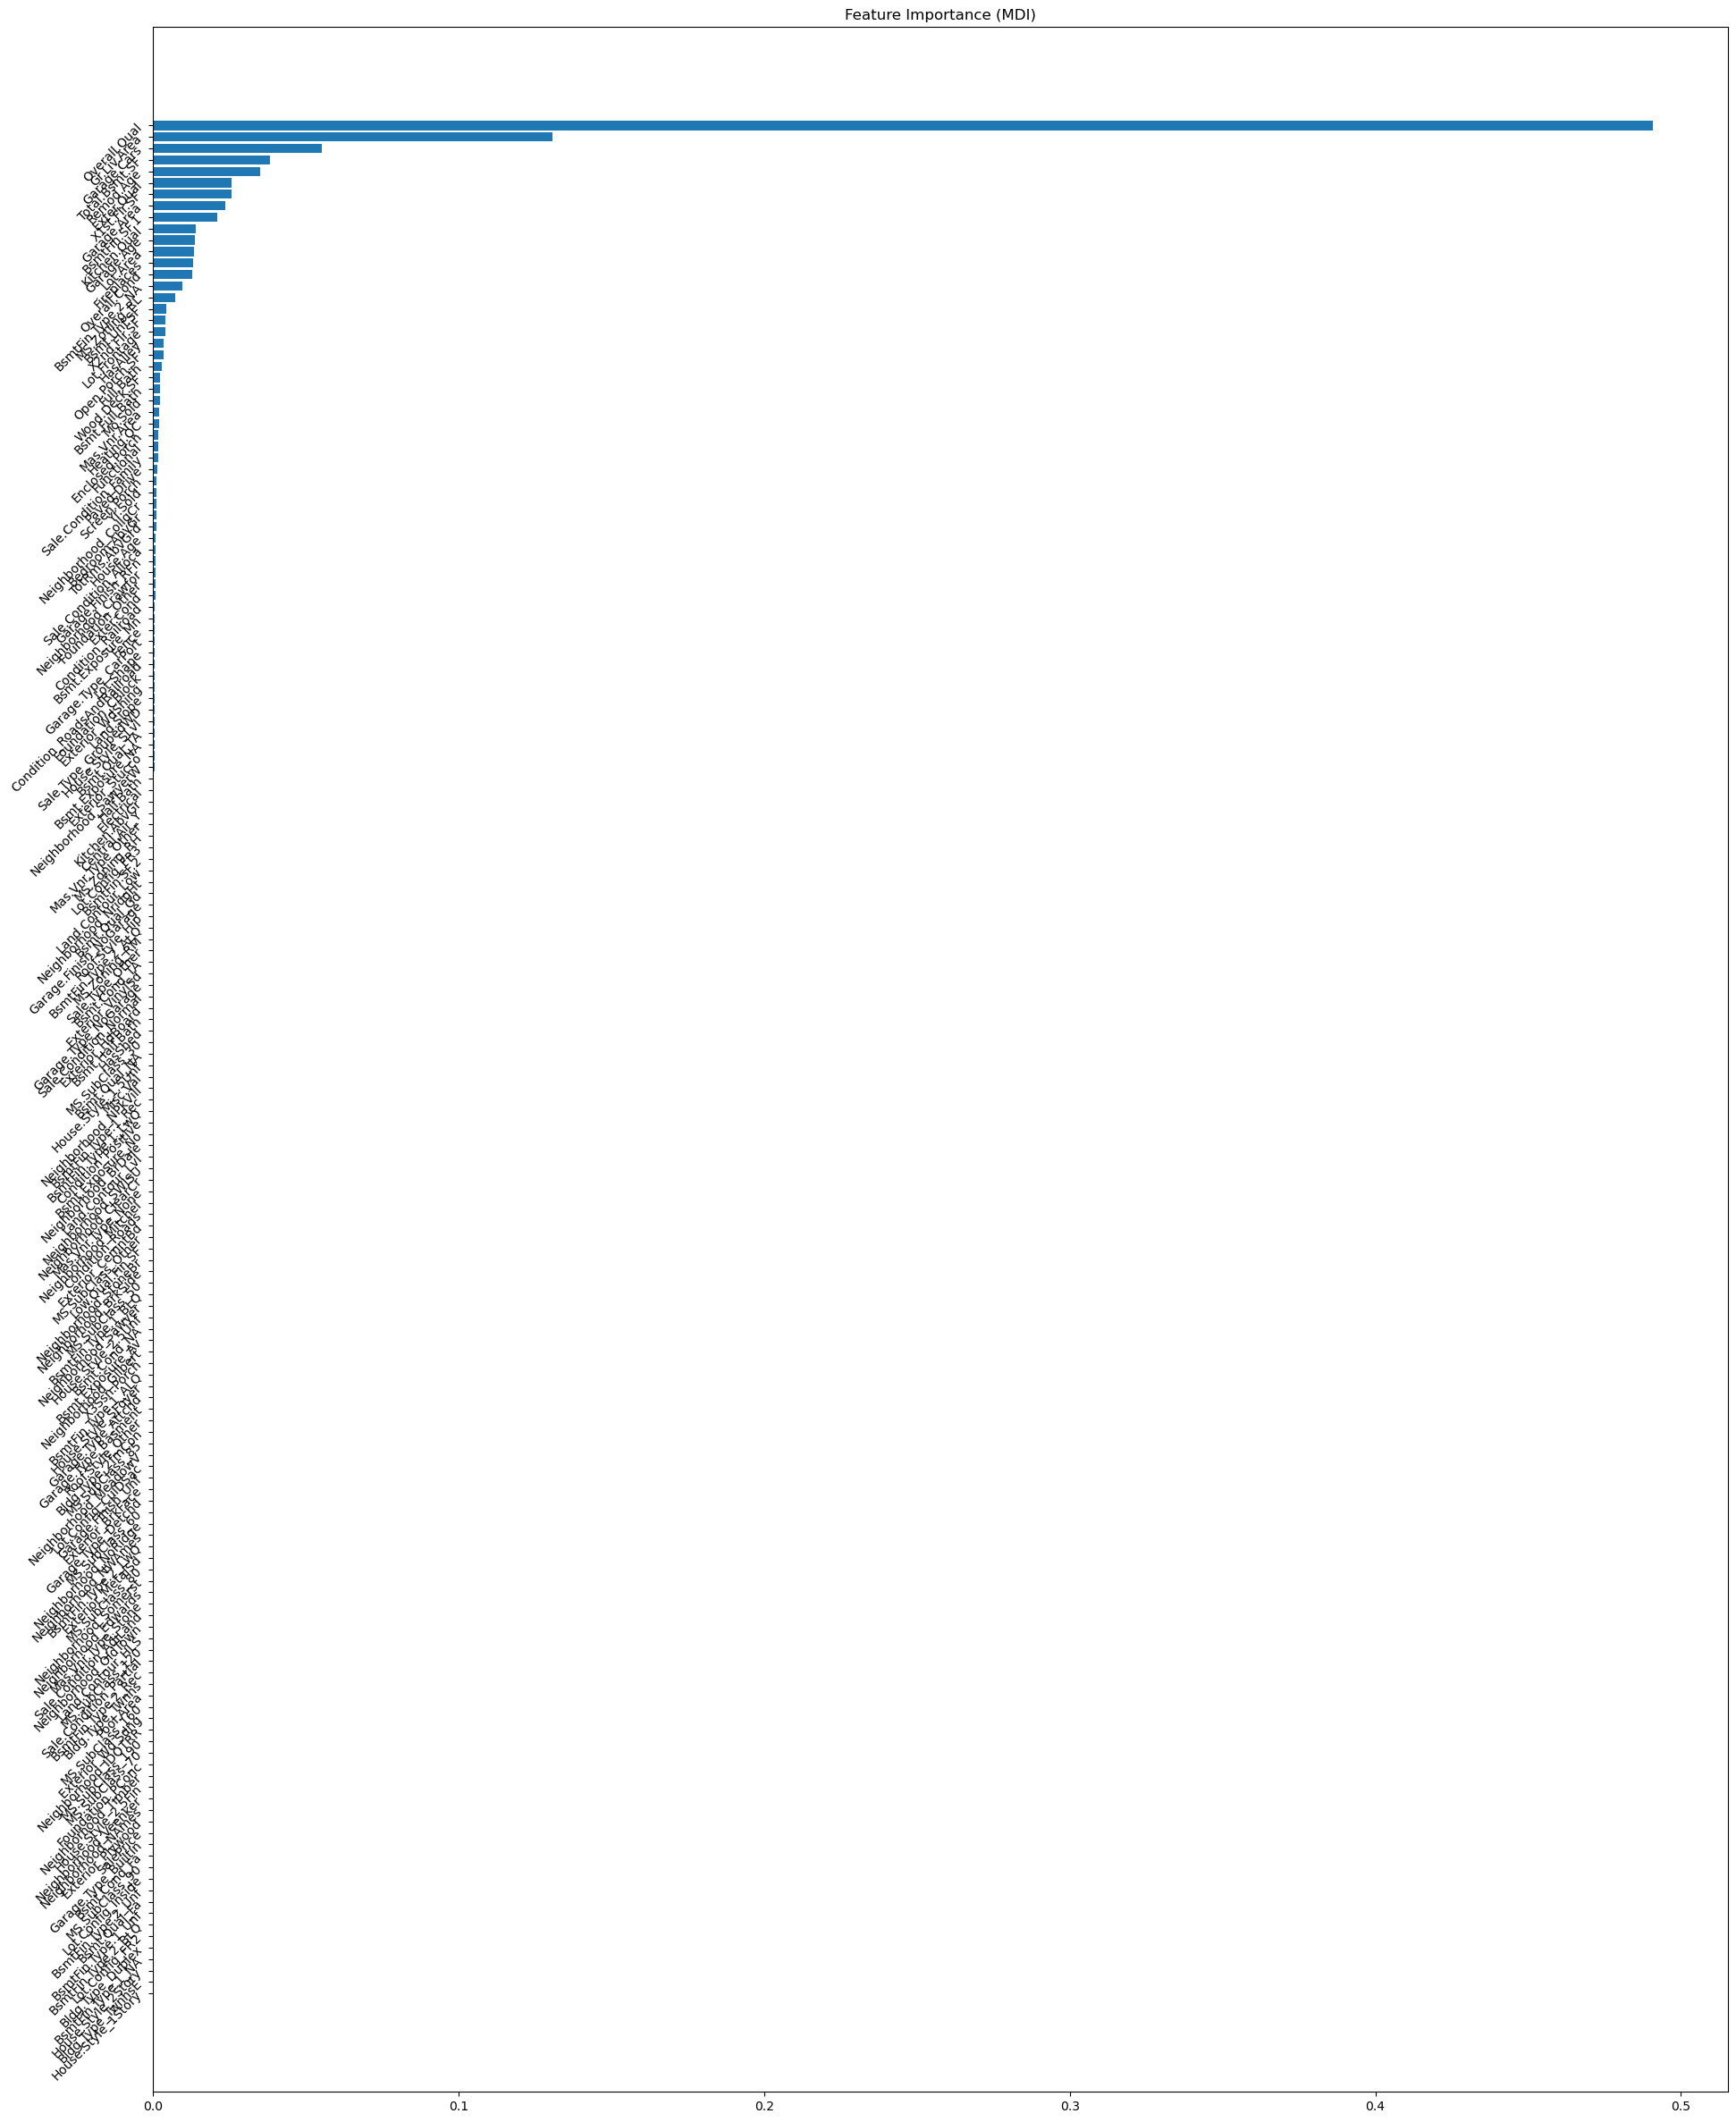

In [78]:
# Faz a média da importância das features
feature_importance = (feature_importance_forest + feature_importance_gbr) / 2
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(50, 30))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(model_data.columns)[sorted_idx], rotation=45, ha="right")
plt.title("Feature Importance (MDI)")



In [99]:
# Filtra as 10 features mais importantes
top_15_features = np.array(model_data.columns)[sorted_idx][-15:]
top_15_features


array(['Lot.Shape', 'BsmtFin.SF.1', 'Lot.Frontage', 'Total.Bsmt.SF',
       'Exter.Cond', 'Overall.Qual', 'Bsmt.Unf.SF', 'Mas.Vnr.Area',
       'Land.Slope', 'Heating.QC', 'Overall.Cond', 'BsmtFin.SF.2',
       'Exter.Qual', 'Lot.Area'], dtype=object)

In [102]:
# print the 15 most important features and their importance score
print('Feature Importance Score')
print('------------------------')
for i,v in enumerate(feature_importance[sorted_idx][-15:]):
    print(f'Feature: {top_15_features[i]}, Score: {v}')
    

Feature Importance Score
------------------------
Feature: Lot.Shape, Score: 0.012928642874511804
Feature: BsmtFin.SF.1, Score: 0.01299327192017279
Feature: Lot.Frontage, Score: 0.013348992112035394
Feature: Total.Bsmt.SF, Score: 0.013628021058966013
Feature: Exter.Cond, Score: 0.014019866127164155
Feature: Overall.Qual, Score: 0.020996077698484883
Feature: Bsmt.Unf.SF, Score: 0.023621301643019746
Feature: Mas.Vnr.Area, Score: 0.0255606419853426
Feature: Land.Slope, Score: 0.02564591399302247
Feature: Heating.QC, Score: 0.03515237281555947
Feature: Overall.Cond, Score: 0.03817005751376151
Feature: BsmtFin.SF.2, Score: 0.05534381199763459
Feature: Exter.Qual, Score: 0.13064986811754262
Feature: Lot.Area, Score: 0.4907190074947551


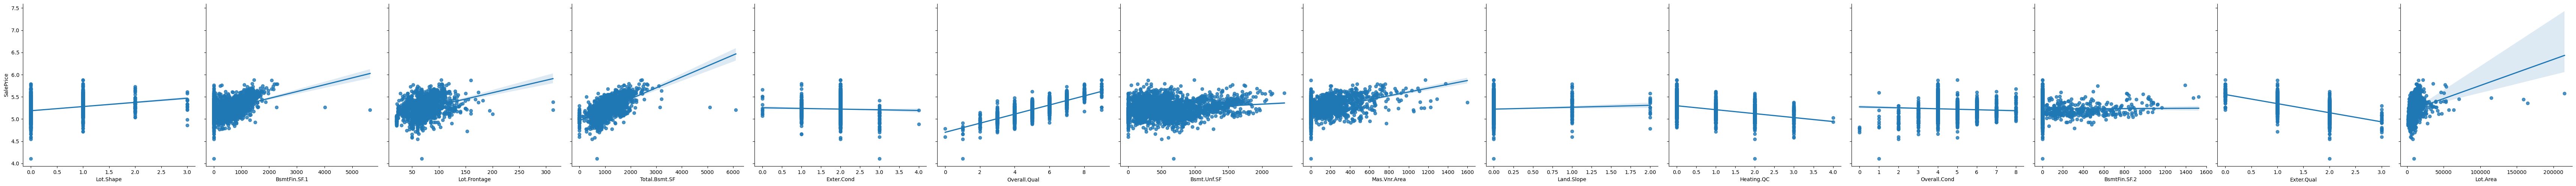

In [97]:
# faz o gráfico de dispersão das 10 features mais importantes
import seaborn as sns

sns.pairplot(model_data, x_vars=top_15_features, y_vars='SalePrice', height=5, aspect=1, kind='reg')


In [100]:
# cria um dataframe com as 10 features mais importantes
top_15_features_df = model_data[top_15_features].copy()
top_15_features_df.head()

# cria um dataframe com as 10 features mais importantes e o target
top_15_features_df = model_data[top_15_features].copy()
top_15_features_df['SalePrice'] = model_data['SalePrice'].copy()
top_15_features_df.corr()


,Lot.Shape,BsmtFin.SF.1,Lot.Frontage,Total.Bsmt.SF,Exter.Cond,Overall.Qual,Bsmt.Unf.SF,Mas.Vnr.Area,Land.Slope,Heating.QC,Overall.Cond,BsmtFin.SF.2,Exter.Qual,Lot.Area,SalePrice
Lot.Shape,1.000000,0.163381,0.137953,0.201748,0.014625,0.248036,0.014786,0.104734,0.112480,-0.144712,-0.083725,0.044026,-0.214704,0.289399,0.311426
BsmtFin.SF.1,0.163381,1.000000,0.205371,0.533889,-0.023984,0.274637,-0.482020,0.299089,0.120293,-0.091706,-0.059800,-0.056870,-0.229290,0.200801,0.407297
Lot.Frontage,0.137953,0.205371,1.000000,0.336705,0.003255,0.218809,0.106536,0.200392,0.056139,-0.077936,-0.064345,0.042011,-0.159344,0.355328,0.344784
Total.Bsmt.SF,0.201748,0.533889,0.336705,1.000000,0.053896,0.542850,0.409612,0.390820,0.050043,-0.253441,-0.185185,0.087399,-0.468992,0.265581,0.624716
Exter.Cond,0.014625,-0.023984,0.003255,0.053896,1.000000,0.018262,0.107674,0.013846,0.004992,0.074052,-0.407849,-0.075492,0.012996,-0.010919,-0.032283
Overall.Qual,0.248036,0.274637,0.218809,0.542850,0.018262,1.000000,0.275121,0.426231,-0.023282,-0.469323,-0.113215,-0.048540,-0.733393,0.110517,0.825587
Bsmt.Unf.SF,0.014786,-0.482020,0.106536,0.409612,0.107674,0.275121,1.000000,0.085895,-0.108362,-0.181036,-0.138065,-0.239814,-0.252976,0.023159,0.195797
Mas.Vnr.Area,0.104734,0.299089,0.200392,0.390820,0.013846,0.426231,0.085895,1.000000,0.023265,-0.169508,-0.138850,-0.016372,-0.361679,0.126555,0.446062
Land.Slope,0.112480,0.120293,0.056139,0.050043,0.004992,-0.023282,-0.108362,0.023265,1.000000,0.025862,0.009547,0.087114,0.030887,0.348339,0.061755
Heating.QC,-0.144712,-0.091706,-0.077936,-0.253441,0.074052,-0.469323,-0.181036,-0.169508,0.025862,1.000000,0.018048,0.060930,0.523918,-0.010537,-0.490290


In [111]:
# feature engineering
# cria uma nova feature com a soma das 15 features mais importantes
top_15_features_df['sum_15_features'] = top_15_features_df[top_15_features].sum(axis=1)
top_15_features_df.head()

,Lot.Shape,BsmtFin.SF.1,Lot.Frontage,Total.Bsmt.SF,Exter.Cond,Overall.Qual,Bsmt.Unf.SF,Mas.Vnr.Area,Land.Slope,Heating.QC,Overall.Cond,BsmtFin.SF.2,Exter.Qual,Lot.Area,SalePrice,sum_15_features
0,1,639.0,141.0,1080.0,2,5,441.0,112.0,0,3,4,0.0,2,31770.0,5.332438,34200.0
1,0,468.0,80.0,882.0,2,4,270.0,0.0,0,2,5,144.0,2,11622.0,5.021189,13481.0
2,1,923.0,81.0,1329.0,2,5,406.0,108.0,0,2,5,0.0,2,14267.0,5.235528,17131.0
3,0,1065.0,93.0,2110.0,2,6,1045.0,0.0,0,0,4,0.0,1,11160.0,5.387390,15486.0
4,1,791.0,74.0,928.0,2,4,137.0,0.0,0,1,4,0.0,2,13830.0,5.278525,15774.0


In [112]:
# correlação da nova feature com o target
top_15_features_df.corr()


,Lot.Shape,BsmtFin.SF.1,Lot.Frontage,Total.Bsmt.SF,Exter.Cond,Overall.Qual,Bsmt.Unf.SF,Mas.Vnr.Area,Land.Slope,Heating.QC,Overall.Cond,BsmtFin.SF.2,Exter.Qual,Lot.Area,SalePrice,sum_15_features
Lot.Shape,1.000000,0.163381,0.137953,0.201748,0.014625,0.248036,0.014786,0.104734,0.112480,-0.144712,-0.083725,0.044026,-0.214704,0.289399,0.311426,0.302601
BsmtFin.SF.1,0.163381,1.000000,0.205371,0.533889,-0.023984,0.274637,-0.482020,0.299089,0.120293,-0.091706,-0.059800,-0.056870,-0.229290,0.200801,0.407297,0.257645
Lot.Frontage,0.137953,0.205371,1.000000,0.336705,0.003255,0.218809,0.106536,0.200392,0.056139,-0.077936,-0.064345,0.042011,-0.159344,0.355328,0.344784,0.384799
Total.Bsmt.SF,0.201748,0.533889,0.336705,1.000000,0.053896,0.542850,0.409612,0.390820,0.050043,-0.253441,-0.185185,0.087399,-0.468992,0.265581,0.624716,0.372473
Exter.Cond,0.014625,-0.023984,0.003255,0.053896,1.000000,0.018262,0.107674,0.013846,0.004992,0.074052,-0.407849,-0.075492,0.012996,-0.010919,-0.032283,-0.004371
Overall.Qual,0.248036,0.274637,0.218809,0.542850,0.018262,1.000000,0.275121,0.426231,-0.023282,-0.469323,-0.113215,-0.048540,-0.733393,0.110517,0.825587,0.174722
Bsmt.Unf.SF,0.014786,-0.482020,0.106536,0.409612,0.107674,0.275121,1.000000,0.085895,-0.108362,-0.181036,-0.138065,-0.239814,-0.252976,0.023159,0.195797,0.068543
Mas.Vnr.Area,0.104734,0.299089,0.200392,0.390820,0.013846,0.426231,0.085895,1.000000,0.023265,-0.169508,-0.138850,-0.016372,-0.361679,0.126555,0.446062,0.186314
Land.Slope,0.112480,0.120293,0.056139,0.050043,0.004992,-0.023282,-0.108362,0.023265,1.000000,0.025862,0.009547,0.087114,0.030887,0.348339,0.061755,0.340864
Heating.QC,-0.144712,-0.091706,-0.077936,-0.253441,0.074052,-0.469323,-0.181036,-0.169508,0.025862,1.000000,0.018048,0.060930,0.523918,-0.010537,-0.490290,-0.041297


# Teste das alterações

In [104]:
# train test split
X = top_15_features_df.drop(columns=['SalePrice']).copy()
y = top_15_features_df['SalePrice'].copy()

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_SEED,
)

In [105]:
# testa o modelo de stacking regressor só com as 15 features mais importantes e a nova feature criada

stack_reg_scores = cross_val_score(stack_reg, Xtrain, ytrain,
                                      scoring="neg_mean_squared_error", cv=8, n_jobs=-1)    
stack_reg_rmse_scores = np.sqrt(-stack_reg_scores)

print(stack_reg_rmse_scores)
print(stack_reg_rmse_scores.mean())

[0.0734749  0.06552744 0.07450697 0.07162598 0.06508289 0.06653333
 0.07016702 0.07358944]
0.07006349617373661


In [113]:
# converte o resultado para o valor original
mean_scores = stack_reg_rmse_scores.mean()
mean_scores = (10**mean_scores - 1) * 100
print(mean_scores)

17.506934379758476


# Analisando Correlações + Features
Inicialmente utilizamos o RandomForest e DecisionTree buscar entender como um modelo complexo interage com nosso banco de dados. Com os benchmarks feitos, buscamos outras formas e modelos que pudessemos implementar, que reduzissem a porcentagem de erro. Com isso chegamos no StakingRegressor em que utilizamos três regressores em formato de stack.

```python
estimators = [
    ('rf', forest_reg),
    ('ls', lasso_reg),
    ('gb', gbr_reg)    
]
```

Após plotar o gráfico das importâncias médias das features, percebemos que apenas 10 features estavam ditando o resultado do modelo. Para solucionar isso, agora daremos inicio a mais uma rodada, adicional a realizada no documento <b>02_analysis_and_preprocessing</b> buscando correlações entre duas ou mais features que poderiam ser múltiplicadas.

## Quais são as 10 Features que ditam o modelo?

1. Lot.Area
2. Exter.Qual
3. BsmtFin.SF.2
4. Overall.Cond
5. Heating.QC
6. Land.Slope
7. Mas.Vn.Area
8. Bsmt.Unf.SF
9. Overall.Qual
10. Exter.Cond

## Quais pares de Features podem ser multiplicados?

Para isso, 